# Replication of paper "Approximate Bayesian computational methods" (2011)

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, KernelDensity
using LaTeXStrings
using SymPy
using ProgressMeter
using VegaLite
using DataFrames
pyplot()

┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/SymPy/KzewI.ji for SymPy [24249f21-da20-56a4-8eb1-6a02cf4ae2e6]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/VegaLite/lrJqi.ji for VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.

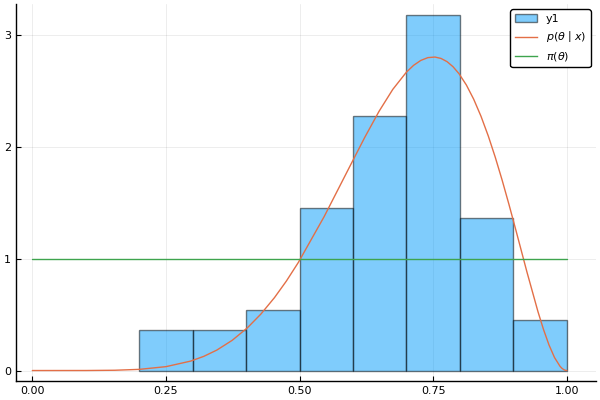

In [2]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

##### a) **Moving Average Model** - MA(2)

In [3]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[1] + u[current] * t[2]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

genMA (generic function with 1 method)

##### b) **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [364]:
using Random
Random.seed!(3)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));
# y     = genMA(u',theta',n,1)

##### c) **Distance Functions and Suffient Statistics**

In [5]:
raw_distance(y,z)         = sqrt(sum((y-z).^2))
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
#     rho = (ay - az)^2+(ay2 - az2)^2 +(sum(y.^2)- sum(z.^2))^2 # Codigo com lag = 0 apresentou melhor resultado aparentemente
    rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end

abcautocov_distance (generic function with 1 method)

Utilizando covarianca com lags 0,

##### d) **Triangular Sampling**
Using rejection sampling to sample uniformly in a triangle

In [6]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end

rand_TriUniform (generic function with 2 methods)

##### e) **Running Algorithm 2**

In [525]:
# Random.seed!(1)
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

In [526]:
autocov_vectorize(z)    = abcautocov_distance(y,z)
dist_vectorize(z)       = raw_distance(y,z)
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
rho_dist    = mapslices(dist_vectorize, z, dims =2)[:];

epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)

theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

z_ac_auto = z[rho_autocov .< epsilon10e4_autocov,:];
epsilon10e4_autocov

13.441211111725181

In [432]:
function Ger_Simga(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end

Ger_Simga (generic function with 1 method)

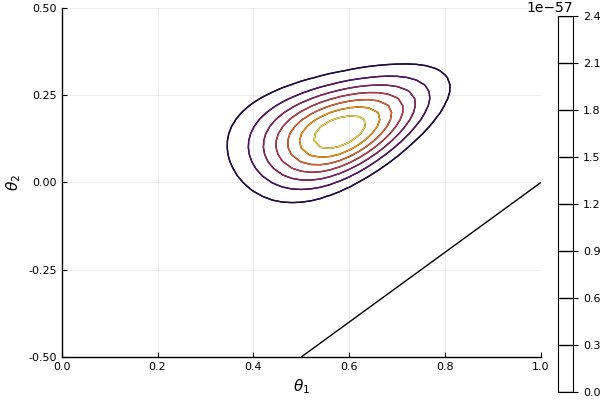

In [433]:
gθ1      = -0:0.02:1
gθ2      = -0.5:0.02:0.5
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
function posterior_mav(θ1,θ2)
    if (θ1>-2 && θ1<2) && (θ1 + θ2>-1) && (θ1 - θ2 < 1)
        return pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)
    else
        return 0
    end
end

Z = map(mamvn, gridθ1, gridθ2)
Z2 = map(posterior_mav, gridθ1, gridθ2)

        
p1 = contour(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
p1 = contour!(gθ1,gθ2, posterior_mav, fill=false,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=true)
# r = rand_TriUniform(1000)
# scatter!(r[:,1],r[:,2])

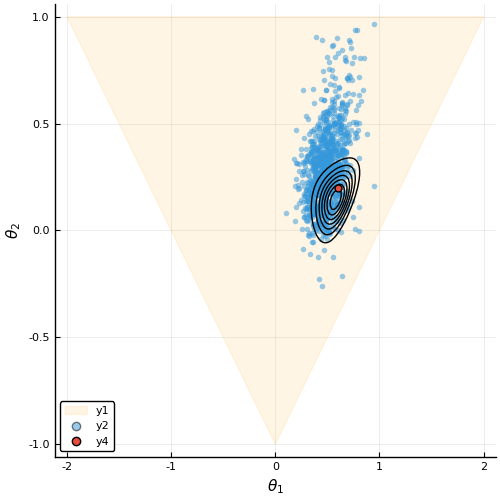

In [434]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0,c="#3498db")


# Contour Plot - True posterior
gθ1      = -0:0.02:1
gθ2      = -0.5:0.02:0.5
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvn(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)
Z = map(mamvn, gridθ1, gridθ2)
p1 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

scatter!([theta[1]],[theta[2]],markersize=5,c="#e74c3c",size=(500,500))

### **Metropolis-Hasting Estimating Marginal**

In [12]:
# M-H
x1 = rand()
x2 = rand() - 0.5
burnin = 1_000
steps = 100_000
C = zeros(steps,2)
Xprevious   = [0;0]

for i=1:steps
    Xnew        = Xprevious + randn(2)*0.1
    alpha = minimum([1,exp(log(mamvn(Xnew[1],Xnew[2])) - log(mamvn(Xprevious[1],Xprevious[2])))])
#     println(1 - alpha, Xnew)
    if rand() < (1 - alpha) # Reject
        Xnew = Xprevious
    end
    C[i,:] = Xnew
    Xprevious = Xnew
end

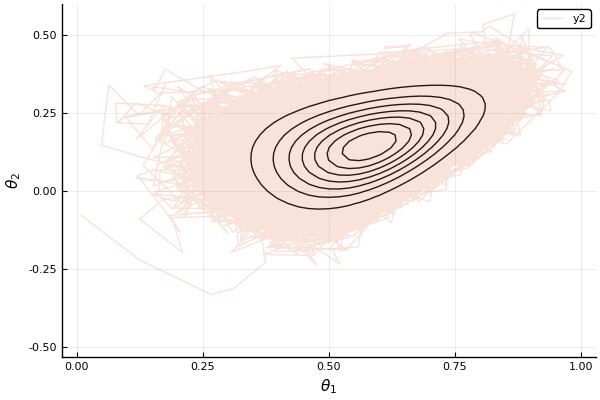

In [13]:
contour(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
plot!(C[:,1],C[:,2],alpha=0.2)

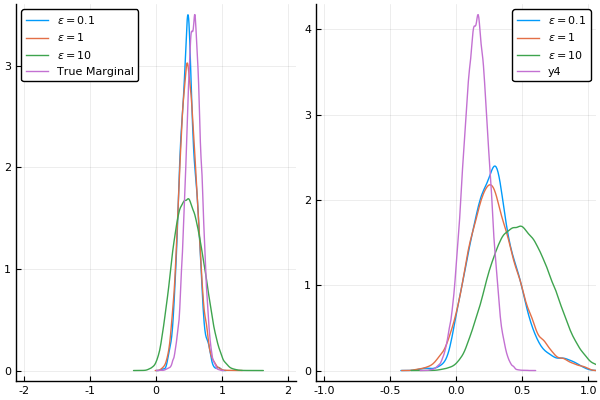

In [14]:
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

epsilon10e3_autocov = quantile(rho_autocov,1/100)
epsilon10e3_dist    = quantile(rho_dist,1/100)
theta_ac_auto10e3 = theta_s[rho_autocov .< epsilon10e3_autocov,:];
theta_ac_dist10e3 = theta_s[rho_dist    .< epsilon10e3_dist,:];

epsilon10e2_autocov = quantile(rho_autocov,10/100)
epsilon10e2_dist    = quantile(rho_dist,10/100)
theta_ac_auto10e2 = theta_s[rho_autocov .< epsilon10e2_autocov,:];
theta_ac_dist10e2 = theta_s[rho_dist    .< epsilon10e2_dist,:];


MH = C[1_000:end,:]

θ1_marginal =  MH[:,1]
θ2_marginal =  MH[:,2]
h1 = density(theta_ac_auto[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=0.1%")
density!(theta_ac_auto10e3[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=1%")
density!(theta_ac_auto10e2[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=10%")
d1 = density!(θ1_marginal,label="True Marginal")
h2 = density(theta_ac_auto[:,2],normalize=true,xlims=[-1,1],label=L"\epsilon=0.1%")
density!(theta_ac_auto10e3[:,2],normalize=true,xlims=[-1,1],label=L"\epsilon=1%")
density!(theta_ac_auto10e2[:,1],normalize=true,xlims=[-1,1],label=L"\epsilon=10%")
d2 = density!(θ2_marginal)
plot(d1,d2,layout=2)

#### Comparing the Distance Metrics

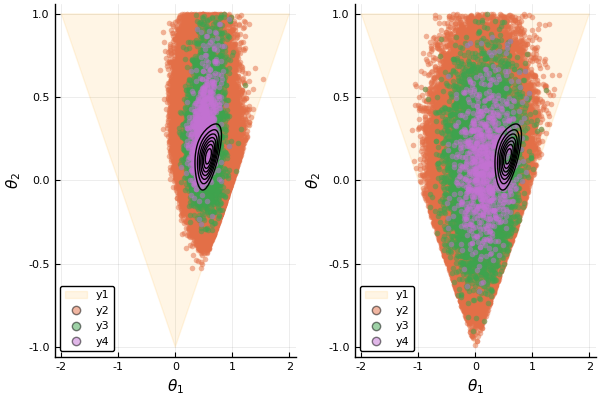

In [15]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_auto10e2[:,1],theta_ac_auto10e2[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_auto10e3[:,1],theta_ac_auto10e3[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
p1 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_dist10e2[:,1],theta_ac_dist10e2[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_dist10e3[:,1],theta_ac_dist10e3[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
scatter!(theta_ac_dist[:,1],theta_ac_dist[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0)
p2 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
plot(p1,p2,layout=2)

### **Alorithm 3** - MCMC-ABC

In [271]:
# Step 1 - Initialisation of the MCMC sampler
N = 10^3        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
theta_init = theta_s[rho_autocov .< epsilon10e4_autocov,:][:];

**ATTENTION**, code below takes long time to run.

Code too slow, needs to be optimized.

In [285]:
N     = 10^6
theta_mcmc = theta_init
theta_now  = theta_init
epsilon = epsilon10e4_autocov
# push!(theta_mcmc,theta_init)
for i=1:N
    theta_new = rand(MvNormal(theta_now,[1. 0.;0. 1.].*0.1))
    u         = randn(n+2) 
    z_new     = MA.((1:n),Ref(u),Ref(theta_new))
    alpha     = minimum([1,
            exp(log(mamvn(theta_new[1],theta_new[2])) - log(mamvn(theta_now[1],theta_now[2])))])
    if (rand() <= alpha) && (abcautocov_distance(y,z_new) <= epsilon)
        theta_now = theta_new
        theta_mcmc= hcat(theta_mcmc,theta_new)
    end
end
theta_mcmc = theta_mcmc';

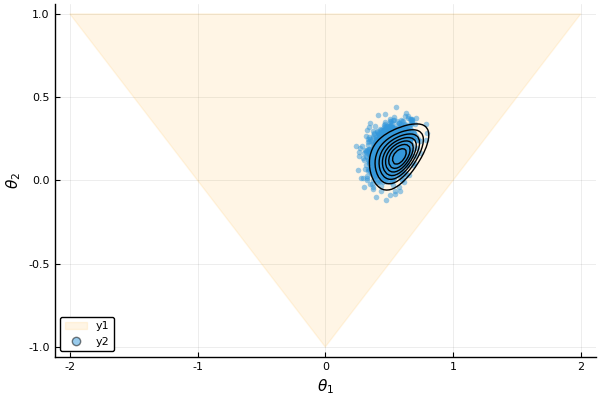

In [287]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_mcmc[:,1],theta_mcmc[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0,c="#3498db")
contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)


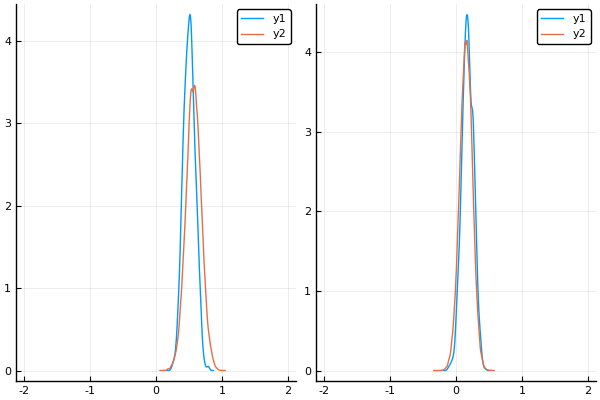

In [288]:
density(theta_mcmc[:,1],normalize=true,xlims=[-2,2])
d1 = density!(θ1_marginal)
density(theta_mcmc[:,2],normalize=true,xlims=[-2,2])
d2 = density!(θ2_marginal)
plot(d1,d2,layout=2)

### **Alorithm 4** - ABC-PMC

In [1038]:
x = rand(10)
w = Weights(rand(10));

In [1103]:
Statistics.var(x,w,corrected=false)
# sum(w.*(x.-mean(w.*x)/sum(w)).^2)/sum(w)
sum(w.*(x.- sum(w.*x)/sum(w)).^2)/sum(w)

0.05526508767984193

## **Post-Processing ABC**

In [16]:
function error_autocov(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = [(ay - az);(ay2 - az2)]
    return rho
end
error_autocov_vectorize(z)    = error_autocov(y,z)
e_autocov = mapslices(error_autocov_vectorize, z, dims =2);

In [17]:
theta_ac_auto10e2
epsilon10e4_autocov
rho_10e2 = rho_autocov[rho_autocov .< epsilon10e2_autocov,:];
e_autocov10e2 = e_autocov[rho_autocov .< epsilon10e2_autocov,:];
e_autocov10e4 = e_autocov[rho_autocov .< epsilon10e4_autocov,:];

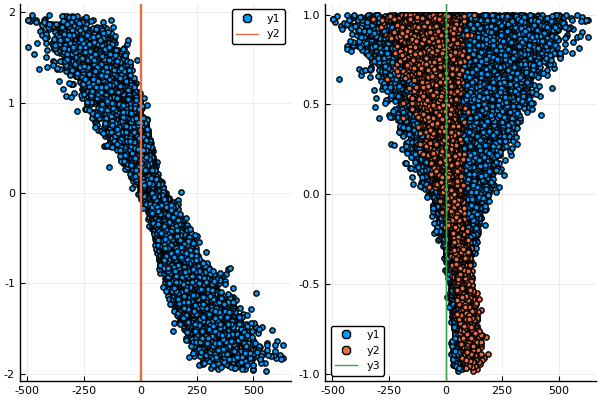

In [18]:
p1 = scatter(e_autocov[1:20_000,1],theta_s[1:20_000,1],marker=:o)
# p1 = scatter!(e_autocov[1:10_000,2],theta_s[1:10_000,1],marker=:o)
p1 = vline!([0,2])
p2 = scatter(e_autocov[1:20_000,1],theta_s[1:20_000,2],marker=:o)
p2 = scatter!(e_autocov[1:20_000,2],theta_s[1:20_000,2],marker=:o)
p2 = vline!([0,2])
plot(p1,p2, layout=2)

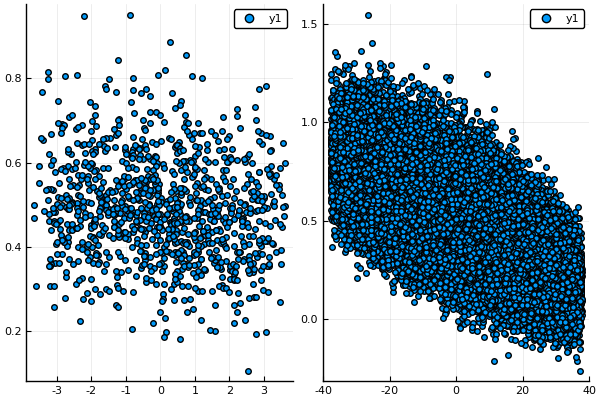

In [19]:
p1 = scatter(e_autocov10e4[:,1],theta_ac_auto[:,1],)
# p1 = scatter!(e_autocov10e4[:,2],theta_ac_auto[:,2],)
p2 = scatter(e_autocov10e2[:,1],theta_ac_auto10e2[:,1],)
# p2 = scatter!(e_autocov10e2[:,2],theta_ac_auto10e2[:,2],)
plot(p1,p2,layout=2)

### Ajustar o cálculo dos pesos. Deve-se usar o Epanechnikov em $||s_i - s||$

In [20]:
σ10e2 = maximum(sqrt.(e_autocov10e2.^2))
plot(Epanechnikov(0,σ10e2))
W10e2 = pdf.(Epanechnikov(0,σ10e2),sqrt.(rho_10e2)[:])
W10e2s2 = pdf.(Epanechnikov(0,σ10e2),e_autocov10e2[:,2])
# W10e4 = [pdf.(Epanechnikov(0,σ10e4),e_autocov10e2[:,1]) pdf.(Epanechnikov(0,σ10e4),e_autocov10e2[:,2])]; #Weights

In [21]:
using LsqFit, GLM

┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/LsqFit/GCdY9.ji for LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/davi/.julia/compiled/v1.0/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1190


In [22]:
m(t, p) = p[1].*t[:,1].+p[2]
model(t, p) = p[1].*t[:,1].+p[2].*t[:,2] .+ p[3]
p0 = [0.5, 0.1]
# fit = curve_fit(m, e_autocov10e2, theta_ac_auto10e2[:,1],W10e2,p0)
# fit.param
p1 = [0.5, 0.5, 0.1]
# fit = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,1],p1)
fit_t1 = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,1],W10e2,p1)
fit_t2 = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,2],W10e2,p1)
# fit_s1 = curve_fit(model, e_autocov10e2, theta_ac_auto10e2[:,1],W10e2s2,p1)
fit_t1.param, fit_t2.param

([-0.00864658, 0.00448274, 0.492908], [-0.000122321, -0.0110067, 0.294482])

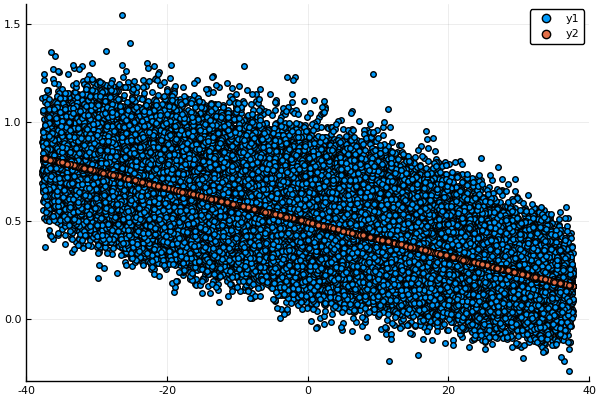

In [23]:
p2 = scatter(e_autocov10e2[:,1],theta_ac_auto10e2[:,1])
scatter!(e_autocov10e2[:,2],fit_t1.param[1].*e_autocov10e2[:,2].+fit_t1.param[3])

In [24]:
theta_r = hcat(theta_ac_auto10e2[:,1] - model(e_autocov10e2,fit_t1.param).+fit_t1.param[3],
    theta_ac_auto10e2[:,2] - model(e_autocov10e2,fit_t2.param).+fit_t2.param[3]);

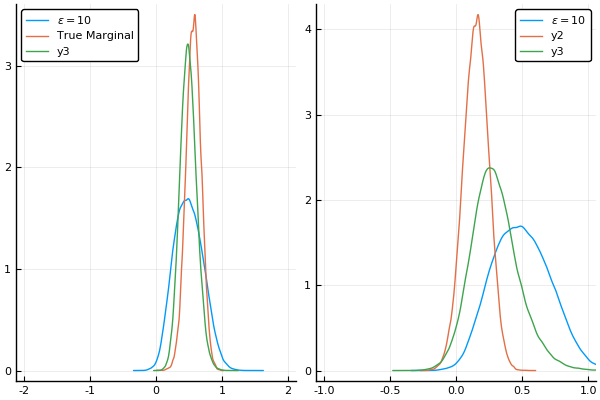

In [25]:
density(theta_ac_auto10e2[:,1],normalize=true,xlims=[-2,2],label=L"\epsilon=10%")
d1 = density!(θ1_marginal,label="True Marginal")
density!(theta_r[:,1],normalize=true)
density(theta_ac_auto10e2[:,1],normalize=true,xlims=[-1,1],label=L"\epsilon=10%")
d2 = density!(θ2_marginal)
density!(theta_r[:,2],normalize=true)
plot(d1,d2,layout=2)

## **ABC and model choice**

In [501]:
MA1(current, u,t) = u[current+1] + u[current] * t[1]

function genMA1(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA1.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

abcautocov_m1 (generic function with 1 method)

In [516]:
teste =zeros(10^6,2)
for i = 1:10^6
    sim = [MA1.(1:n, Ref(randn(n+2)), Ref([0.6 0.2])) MA.(1:n, Ref(randn(n+2)), Ref([0.6 0.2])) y]
    teste[i,:] = [abcautocov_distance(y,sim[:,1]) abcautocov_distance(y,sim[:,2])]
end

# h1 = histogram(teste[:,1],normalize=true,nbins=100)
# h2 = histogram!(teste[:,2],alpha=0.5,normalize=true,nbins=100)
q = 0.01/100
testetotal = sum(teste[:,1] .< quantile(teste[:,2],q)) + sum(teste[:,2] .< quantile(teste[:,2],q))
M1_freq = sum(teste[:,1] .< quantile(teste[:,2],q))/testetotal
M2_freq = sum(teste[:,2] .< quantile(teste[:,2],q))/testetotal

0.7692307692307693

In [528]:
# Random.seed!(1)
N = 10^6        # number of trials
n = length(y) # sample size
theta_ms= rand_TriUniform(N)
u       = randn(N,n+2)
zm1     = genMA1(u,theta_ms,n,N);
zm2     = genMA(u,theta_ms,n,N);

rho_M2 = mapslices(autocov_vectorize, zm2, dims =2)[:];
epsilon10e4_M2 = quantile(rho_M2[:],0.1/100)

13.73775003774222

In [1104]:
Nm = 10_000
mi = zeros(Nm)
θM = zeros(Nm,2)
for i = 1:Nm
    M = 0
    θm= [0.,0.]
    ρ = epsilon10e4_autocov*2
    while ρ > epsilon10e4_autocov
        M  = rand(1:2)
        u  = randn(n+2)
        if M == 1
            θm = rand(2).*2 .-1
            zm = MA1.((1:n),Ref(u),Ref(θm));
        else
            θm = rand_TriUniform(1)
            zm = MA.((1:n),Ref(u),Ref(θm));
        end
        ρ = abcautocov_distance(y,zm)
    end 
    mi[i]   = M
    θM[i,:] = θm
end

In [1105]:
sum(mi .== 2)/Nm

0.5452

### True Posterior - Bayes Factor

In [556]:
# MH; # Sample from true distribution
# N = length(MH[:,1])
# u       = randn(N,n+2)
# zm1_true= genMA1(u,MH,n,N);
# zm2_true= genMA(u,MH,n,N);

# rho_M1 = mapslices(autocov_vectorize, zm1_true, dims =2)[:];
# rho_M2 = mapslices(autocov_vectorize, zm2_true, dims =2)[:];
# epsilon10e4_M2 = quantile(rho_M2[:],0.1/100)

In [557]:
function Ger_SimgaM1(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 2
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 99
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 100
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
        else
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        end
    end

    return Σ
end

Ger_SimgaM1 (generic function with 1 method)

In [632]:
# Contour Plot - True posterior
gθ1      = -1:0.02:1
gθ2      = -0.5:0.02:0.5
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvn(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)
mamvnM1(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM1(θ1,θ2,y)),y)

θmle_m1 = [0,0]
θmle_m2 = [0,0]
mle_m1  = 0
mle_m2  = 0
for t1 in gθ1
    if mamvnM1(θmle_m1[1],θmle_m1[2]) < mamvnM1(t1,0)
        θmle_m1 = [t1,0]
        mle_m1  = mamvnM1(t1,0)
    end
end

for t1 in gθ1
    for t2 in gθ2
        if mamvn(θmle_m2[1],θmle_m2[2]) < mamvn(t1,t2)
            θmle_m2 = [t1,t2]
            mle_m2  = mamvn(t1,t2)
        end
    end
end
# K_total = 0
# K_total = exp.(log.(mamvn.(MH[:,1],MH[:,2]))- log.(mamvnM1.(MH[:,1],MH[:,2])))
# for i=1:length(MH[:,1])
# end
# p1 = contour(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
#     xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
# p1 = contour(gθ1,gθ2, mamvnM1, fill=false,c=:black,levels=8,
#     xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

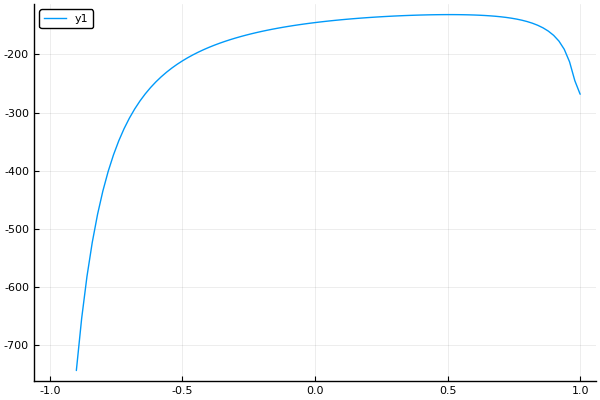

In [720]:
θmle_m2,θmle_m1
# mle_m1,mle_m2

# mle_m2/mle_m1
mle_m2

2.3546519913802086e-57

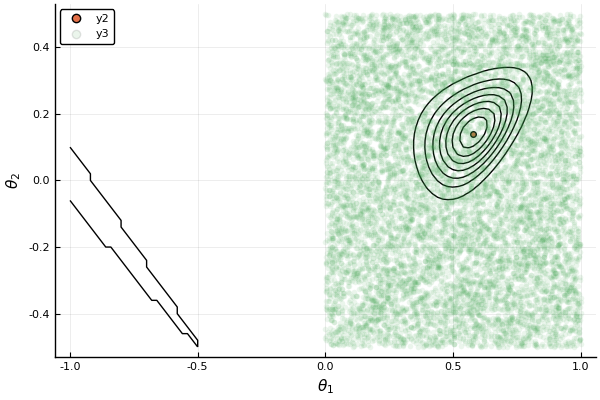

In [680]:
p1 = contour(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
scatter!([θmle_m2[1]],[θmle_m2[2]])
scatter!(rand(10_000),rand(10_000) .- 0.5,alpha=0.1,markerstrokewidth=0)

In [794]:
Z = mamvn.(rand(10_000),rand(10_000) .- 0.5)
Zm2 = sum(Z)/10_000

1.4826820330014471e-58

In [799]:
Ns = 10_000
Zm1 = sum(mamvnM1.(rand(Ns),0))/Ns

1.7519480355743897e-58

In [784]:
Ns = 10_000
samples = rand_TriUniform(Ns)
pyM2 = sum(mamvn.(samples[:,1],samples[:,2]))/Ns
samples = rand(Ns,2).*4 .-2
pyM1 = sum(mamvnM1.(samples[:,1],samples[:,2]))/Ns

4.340594732475048e-59

In [785]:
pyM1, pyM2

(4.340594732475048e-59, 3.5499313479022236e-59)

In [757]:
samples = rand(Ns,2).*2 .-1

0.4899443394499082

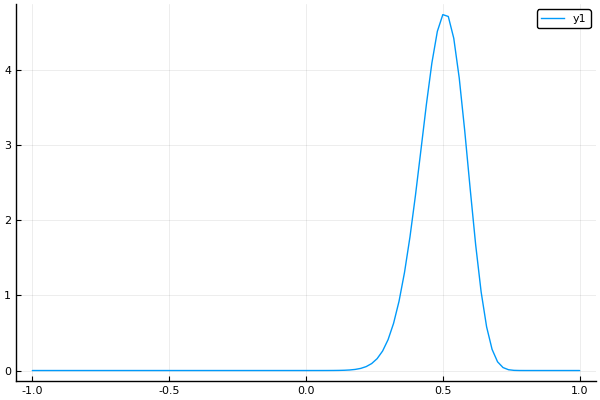

In [725]:
# Normalize M1 distribution
plot(gθ1,exp.(log.(mamvnM1.(gθ1,0)) .- log(Zm1)))

# mle_m2/mle_m1 * Zm1/Zm2